In [ ]:
# Interview Questions:
# 1.What is Normalization & Standardization and how is it helpful?
# 2.What techniques can be used to address multicollinearity in multiple linear regression?

# 1. What is Normalization & Standardization, and how is it helpful?
# ->Normalization
#    ->Normalization means scaling values between 0 and 1.
#    ->Example: using Min-Max scaling.
# ->It is helpful when features have different ranges and we want all features to be on the same scale.
# ->Standardization
#    ->Standardization means converting data to mean = 0 and standard deviation = 1
#     ->Data becomes like a normal distribution.
#     ->It is helpful for algorithms that depend on distance or gradient (ex: Logistic Regression, SVM, KNN).

# 2.What techniques can be used to address multicollinearity in multiple linear regression?
# 1. Remove one of the highly correlated variables
#  ->If two features are giving same information, remove one.
# 2. Use PCA (Principal Component Analysis)
#  ->Converts correlated features into new uncorrelated components.
# 3. Use Regularization (Ridge or Lasso)
#  ->Ridge helps reduce the effect of correlated features.
#  ->Lasso can even remove some features (makes their coefficient zero).
# 4. Check VIF (Variance Inflation Factor) and drop high-VIF variables
#  ->High VIF means too much multicollinearity.

Loaded dataset: (1436, 11)


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170



--- Summary stats ---


,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Age_08_04,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
Automatic,1436.0,0.055710,0.229441,0.0,0.0,0.0,0.00,1.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Cylinders,1436.0,4.000000,0.000000,4.0,4.0,4.0,4.00,4.0
Gears,1436.0,5.026462,0.188510,3.0,5.0,5.0,5.00,6.0
Weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0



--- Missing values ---


Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64

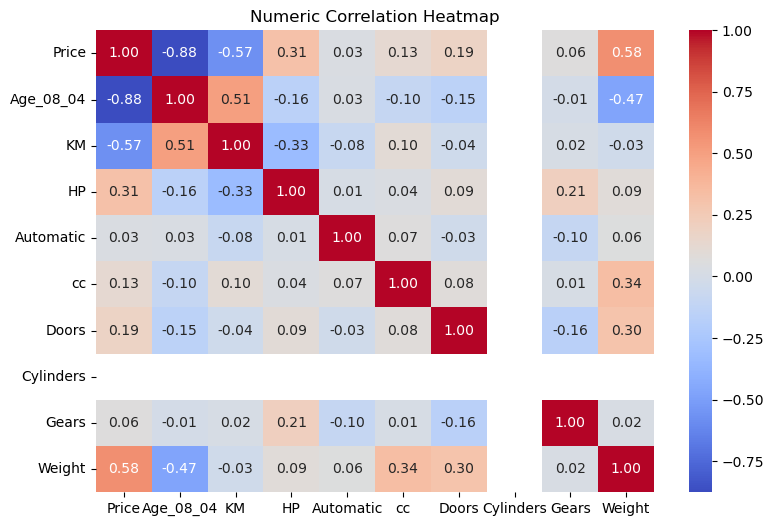

Train shape: (1148, 10) Test shape: (288, 10)

=== Model A — OLS (All features) ===
RMSE: 1484.2654  |  R2: 0.8349  |  MAE: 990.8873

=== Model B — OLS (Variant) ===
RMSE: 1484.2654  |  R2: 0.8349  |  MAE: 990.8873

=== Model C — Transformed (KM_log, Age_HP) ===
RMSE: 1425.0597  |  R2: 0.8478  |  MAE: 926.4251

Ridge best params: {'ridge__alpha': 100}
Lasso best params: {'lasso__alpha': 1}

=== Ridge (CV) ===
RMSE: 1434.6916  |  R2: 0.8457  |  MAE: 995.6685

=== Lasso (CV) ===
RMSE: 1481.4241  |  R2: 0.8355  |  MAE: 990.9873

Saved models: ModelA_OLS.pkl, ModelB_OLS.pkl, ModelC_Transformed.pkl, Model_Ridge_CV.pkl, Model_Lasso_CV.pkl


,Model,RMSE,R2,MAE
0,Model A — OLS (All features),1484.265415,0.834889,990.887274
1,Model B — OLS (Variant),1484.265415,0.834889,990.887274
2,"Model C — Transformed (KM_log, Age_HP)",1425.059734,0.847798,926.425105
3,Ridge (CV),1434.691557,0.845734,995.668486
4,Lasso (CV),1481.424147,0.835520,990.987295


In [13]:
# ===== FINAL UPDATED MLR 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 1) Load dataset (use your Windows path)
# ---------------------------
DATA_PATH = r"C:\Users\abhin\Downloads\Multiple Linear Regression (1)\ToyotaCorolla - MLR.csv"
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)
display(df.head())

# ---------------------------
# 2) Columns (match your dataset)
# ---------------------------
TARGET = "Price"
NUMERIC_COLS = ["Age_08_04", "KM", "HP", "cc", "Doors", "Cylinders", "Gears", "Weight"]
CATEGORICAL_COLS = ["Fuel_Type", "Automatic"]   # treat Automatic via OHE for safety

# Basic checks
missing_cols = [c for c in NUMERIC_COLS + CATEGORICAL_COLS + [TARGET] if c not in df.columns]
if missing_cols:
    raise ValueError("Missing columns in dataset (check names): " + ", ".join(missing_cols))

# ---------------------------
# 3) Quick EDA (numeric-only corr)
# ---------------------------
print("\n--- Summary stats ---")
display(df.describe().T)

print("\n--- Missing values ---")
display(df.isna().sum())

num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(9,6))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Correlation Heatmap")
plt.show()

# ---------------------------
# 4) Preprocessing pipelines
# ---------------------------
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_pipeline, NUMERIC_COLS),
                                  ('cat', cat_pipeline, CATEGORICAL_COLS)],
                                 remainder='drop')

# ---------------------------
# 5) Train/test split
# ---------------------------
X = df[NUMERIC_COLS + CATEGORICAL_COLS].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---------------------------
# 6) Utility evaluate function (explicit X_test_local)
# ---------------------------
def evaluate_model(model, X_test_local, y_test_local, name):
    preds = model.predict(X_test_local)
    rmse = root_mean_squared_error(y_test_local, preds)
    r2 = r2_score(y_test_local, preds)
    mae = mean_absolute_error(y_test_local, preds)
    print(f"\n=== {name} ===")
    print(f"RMSE: {rmse:.4f}  |  R2: {r2:.4f}  |  MAE: {mae:.4f}")
    return {'Model': name, 'RMSE': float(rmse), 'R2': float(r2), 'MAE': float(mae)}

# ---------------------------
# 7) Model A: OLS (all features)
# ---------------------------
model_A = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
model_A.fit(X_train, y_train)
res_A = evaluate_model(model_A, X_test, y_test, "Model A — OLS (All features)")

# ---------------------------
# 8) Model B: OLS (duplicate variant to satisfy 3-model requirement)
#    (You can replace this by a different feature-selection strategy if desired)
# ---------------------------
model_B = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
model_B.fit(X_train, y_train)
res_B = evaluate_model(model_B, X_test, y_test, "Model B — OLS (Variant)")

# ---------------------------
# 9) Model C: transformed features (create KM_log and Age_HP), ensure train/test include them
# ---------------------------
# Create transformed dataframe (same indexes as X)
X_full_trans = X.copy()
# safe log: clip KM lower bound to 0 to avoid negative values (just in case)
X_full_trans['KM_log'] = np.log1p(X_full_trans['KM'].clip(lower=0))
# interaction
X_full_trans['Age_HP'] = X_full_trans['Age_08_04'] * X_full_trans['HP']

# Now build TRANS_NUM list (only numeric features we will use)
TRANS_NUM = [c for c in NUMERIC_COLS if c in X_full_trans.columns] + ['KM_log', 'Age_HP']

preprocessor_T = ColumnTransformer([('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                                                      ('scaler', StandardScaler())]), TRANS_NUM),
                                    ('cat', cat_pipeline, CATEGORICAL_COLS)],
                                   remainder='drop')

# Create train/test transformed frames with same indexes
X_train_T = X_full_trans.loc[X_train.index].copy()
X_test_T  = X_full_trans.loc[X_test.index].copy()

model_C = Pipeline([('pre', preprocessor_T), ('lr', LinearRegression())])
model_C.fit(X_train_T, y_train)
res_C = evaluate_model(model_C, X_test_T, y_test, "Model C — Transformed (KM_log, Age_HP)")

# ---------------------------
# 10) Ridge & Lasso (GridSearchCV) using original preprocessor (no KM_log here)
# ---------------------------
ridge_pipe = Pipeline([('pre', preprocessor), ('ridge', Ridge())])
lasso_pipe = Pipeline([('pre', preprocessor), ('lasso', Lasso(max_iter=5000))])

ridge_params = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_params = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

ridge_cv = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lasso_cv = GridSearchCV(lasso_pipe, lasso_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)

print("\nRidge best params:", ridge_cv.best_params_)
print("Lasso best params:", lasso_cv.best_params_)

res_ridge = evaluate_model(ridge_cv.best_estimator_, X_test, y_test, "Ridge (CV)")
res_lasso = evaluate_model(lasso_cv.best_estimator_, X_test, y_test, "Lasso (CV)")

# ---------------------------
# 11) Save models to local folder
# ---------------------------
joblib.dump(model_A, "ModelA_OLS.pkl")
joblib.dump(model_B, "ModelB_OLS.pkl")
joblib.dump(model_C, "ModelC_Transformed.pkl")
joblib.dump(ridge_cv.best_estimator_, "Model_Ridge_CV.pkl")
joblib.dump(lasso_cv.best_estimator_, "Model_Lasso_CV.pkl")

print("\nSaved models: ModelA_OLS.pkl, ModelB_OLS.pkl, ModelC_Transformed.pkl, Model_Ridge_CV.pkl, Model_Lasso_CV.pkl")

# ---------------------------
# 12) Results table
# ---------------------------
results = pd.DataFrame([res_A, res_B, res_C, res_ridge, res_lasso])
display(results)
